Passo 1: Setup do Código

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv

e:\01-projetos\11-work\11.34-engenharia-vetorial\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.5) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [3]:
env_path = Path.cwd().joinpath('..', '..', '.env').resolve()
loaded = load_dotenv(dotenv_path=env_path)  # True se carregou
print("Carregou .env:", loaded, "->", env_path)

# Verificar uma variável
# print("GOOGLE_API_KEY:", os.getenv("GOOGLE_API_KEY"))

Carregou .env: True -> E:\01-projetos\11-work\11.34-engenharia-vetorial\.env


In [4]:

# Inicializar modelo Gemini
# O 'text-embedding-004' suporta Matryoshka nativamente
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

# Frases para teste
frase_base = "O gato dorme no sofá"
frase_similar = "O felino descansa na poltrona"
frase_oposta = "O robô solda o aço na fábrica"

# Função para calcular similaridade de cosseno manual
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

Passo 2: Gerar e Cortar Vetores

In [5]:
# Gerar vetor completo (768 dimensões)
vec_base = embeddings.embed_query(frase_base)
vec_sim = embeddings.embed_query(frase_similar)
vec_op = embeddings.embed_query(frase_oposta)

print(f"Tamanho original: {len(vec_base)} dimensões")


Tamanho original: 768 dimensões


In [9]:

# Simular Matryoshka: Cortar os vetores (Slicing)
dims = [768, 512, 256, 128, 64]
resultados = []

print("\n--- Impacto da Redução de Dimensões ---")
print(f"{'Dimensões':<10} | {'Simil. (Gato vs Felino)':<25} | {'Simil. (Gato vs Robô)':<25}")


for d in dims:
    # Cortar o vetor (pegar os primeiros d elementos)
    cut_base = vec_base[:d]
    cut_sim = vec_sim[:d]
    cut_op = vec_op[:d]
    
    # Calcular similaridade nos vetores cortados
    score_pos = cos_sim(cut_base, cut_sim)
    score_neg = cos_sim(cut_base, cut_op)
    
    resultados.append((d, score_pos))
    print(f"{d:<10} | {score_pos:.4f}{' (Mantido!)   ' if score_pos > 0.8 else ''}      | {score_neg:.4f}")


--- Impacto da Redução de Dimensões ---
Dimensões  | Simil. (Gato vs Felino)   | Simil. (Gato vs Robô)    
768        | 0.8994 (Mantido!)         | 0.4715
512        | 0.8995 (Mantido!)         | 0.4810
256        | 0.9108 (Mantido!)         | 0.5158
128        | 0.9257 (Mantido!)         | 0.4938
64         | 0.9232 (Mantido!)         | 0.4777


Passo 3: Visualização (Gráfico)

Você verá que a linha de similaridade se mantém alta mesmo caindo para 128 dimensões.

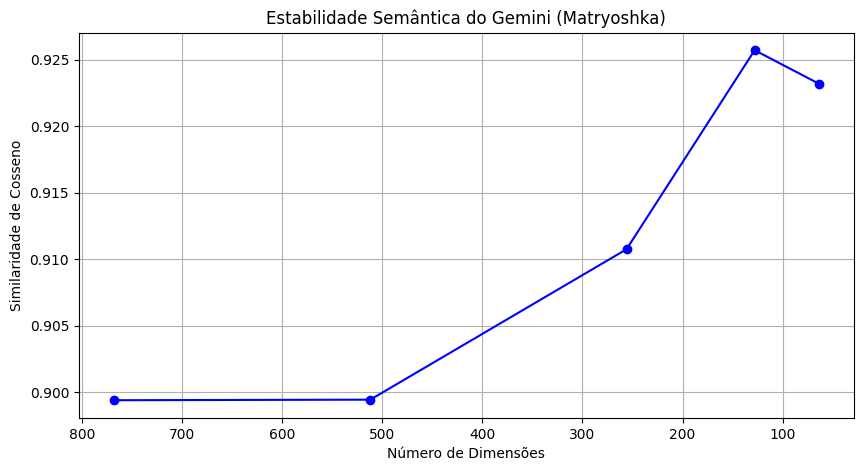

In [10]:
# Plotar a queda de precisão
x = [r[0] for r in resultados]
y = [r[1] for r in resultados]

plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.title("Estabilidade Semântica do Gemini (Matryoshka)")
plt.xlabel("Número de Dimensões")
plt.ylabel("Similaridade de Cosseno")
plt.gca().invert_xaxis() # Inverter eixo para mostrar redução da esq p/ dir
plt.grid(True)
plt.show()